## Regression

We will use regression to predict financial data for Enron employees and associates. 

### Once you know some financial data about an employee, like their salary, what would you predict for the size of their bonus?

If you know someone's salary, stock options are you able to predict how much money they're makking in their bonuses every year. You have to use a regression to find out

In [269]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('agg')
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from time import time
import random

%matplotlib inline

In [270]:
"""
convert dos linefeeds (crlf) to unix (lf)
usage: dos2unix.py 
"""
original = "files/final_project_dataset_modified.pkl"
destination = "files/final_project_dataset_modified_unix.pkl"

content = ''
outsize = 0
with open(original, 'rb') as infile:
    content = infile.read()
with open(destination, 'wb') as output:
    for line in content.splitlines():
        outsize += len(line) + 1
        output.write(line + str.encode('\n'))

print("Done. Saved %s bytes." % (len(content)-outsize))

Done. Saved 6564 bytes.


### #1 Prepare the Features and Target

We'll be using the salary to predict the bonus.

#### What is your regression target?
* `bonus` 
#### What is the input being used to find it?
* `salary`

In [271]:
from formatting_features import featureFormat, targetFeatureSplit

In [272]:
# load the data as a dictionary
dictionary = pickle.load( open("files/final_project_dataset_modified_unix.pkl", "rb") )

In [273]:
# let's see the first employee
dictionary['METTS MARK']

{'salary': 365788,
 'to_messages': 807,
 'deferral_payments': 'NaN',
 'total_payments': 1061827,
 'loan_advances': 'NaN',
 'bonus': 600000,
 'email_address': 'mark.metts@enron.com',
 'restricted_stock_deferred': 'NaN',
 'deferred_income': 'NaN',
 'total_stock_value': 585062,
 'expenses': 94299,
 'from_poi_to_this_person': 38,
 'exercised_stock_options': 'NaN',
 'from_messages': 29,
 'other': 1740,
 'from_this_person_to_poi': 1,
 'poi': False,
 'long_term_incentive': 'NaN',
 'shared_receipt_with_poi': 702,
 'restricted_stock': 585062,
 'director_fees': 'NaN'}

In [274]:
len(dictionary)

143

In [275]:
enron_data = pd.DataFrame.from_dict(dictionary, orient='index')
enron_data.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,63014,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


In [97]:
# reindex the table
enron_data.reset_index(level=enron_data.index.names, inplace=True)

In [98]:
# rename index column
enron_data.rename(columns={'index':'name'}, inplace=True)

In [99]:
# check the changes
enron_data.head()

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
0,ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
1,BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
3,BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
4,BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


In [100]:
enron_data.shape

(143, 22)

In [101]:
# save it to a csv file
enron_data.to_csv('final_project_dataset.csv', index=False)

In [212]:
# test the new file
enron_df = pd.read_csv('final_project_dataset.csv')
enron_df.head()

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
0,ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,NaN,4175000.0,phillip.allen@enron.com,-126027.0,-3081055.0,...,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,NaN
1,BADUM JAMES P,NaN,NaN,178980.0,182466.0,NaN,NaN,NaN,NaN,NaN,...,NaN,257817.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,NaN,NaN,james.bannantine@enron.com,-560222.0,-5104.0,...,39.0,4046157.0,29.0,864523.0,0.0,False,NaN,465.0,1757552.0,NaN
3,BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,NaN,NaN,-1386055.0,...,NaN,6680544.0,NaN,2660303.0,NaN,False,1586055.0,NaN,3942714.0,NaN
4,BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,frank.bay@enron.com,-82782.0,-201641.0,...,NaN,NaN,NaN,69.0,NaN,False,NaN,NaN,145796.0,NaN


In [324]:
### list the features you want to look at--first item in the 
### list will be the "target" feature
features_list = ["bonus", "salary"]
data = featureFormat( dictionary, features_list, remove_any_zeroes=True)
target, features = targetFeatureSplit( data )

In [325]:
# salary, bonus
features[:3], target[:3]

([array([365788.]), array([267102.]), array([170941.])],
 [600000.0, 1200000.0, 350000.0])

In [326]:
len(features), len(target)

(79, 79)

In [327]:
# training-testing split the features and target 
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.5, random_state=42)

In [320]:
len(feature_train), len(feature_test), len(target_train), len(target_test)

(27, 28, 27, 28)

In [282]:
train_color = "b"
test_color = "r"

### #2 Regression

In [283]:
def model_regression(feature_train, target_train):
    
    # create classifier
    reg = LinearRegression()
    # train on the training set
    reg.fit(feature_train, target_train)
    
    return reg

In [328]:
reg = model_regression(feature_train, target_train)

### #3 Make Predictions

In [285]:
pred = reg.predict(feature_test)

In [335]:
def view_regression(feature_train, feature_test, target_train, target_test, pred):
    plt.clf()
    plt.scatter(feature_train, target_train, color="b", label="train data")
    plt.scatter(feature_test, target_test, color="r", label="test data")
    
    # plot
    reg.fit(feature_test, target_test)
    plt.plot(feature_train, reg.predict(feature_train), color="r") 
    
    plt.plot(feature_test, pred, color="black")
    plt.legend(loc=2)
    plt.xlabel("salary")
    plt.ylabel("bonus")
    plt.show();

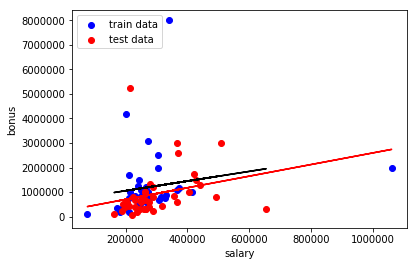

In [336]:
view_regression(feature_train, feature_test, target_train, target_test, pred)

### #4 What are the slope and intercept?

In [290]:
print('slope:', reg.coef_[0])

slope: 1.9701728684684925


In [291]:
print('intercept: ', reg.intercept_)

intercept:  662220.417601581


In [268]:
enron_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       143 non-null float64
to_messages                  143 non-null object
deferral_payments            143 non-null object
total_payments               143 non-null object
loan_advances                143 non-null object
bonus                        143 non-null float64
email_address                143 non-null object
restricted_stock_deferred    143 non-null object
deferred_income              143 non-null object
total_stock_value            142 non-null object
expenses                     143 non-null object
from_poi_to_this_person      143 non-null object
exercised_stock_options      143 non-null object
from_messages                143 non-null object
other                        143 non-null object
from_this_person_to_poi      143 non-null object
poi                          143 non-null bool
long_term_incentive          143 non-null objec

In [235]:
enron_data[['salary', 'bonus']] = enron_data[['salary', 'bonus']].astype('float64').fillna(0)

In [220]:
data_clean = enron_data[['salary', 'bonus']].drop(enron_data[['salary', 'bonus']].query('salary == 0 and bonus ==0').index)

In [240]:
X = data_clean[['salary']]
y = data_clean[['bonus']]

In [252]:
X.shape, y.shape

((79, 1), (79, 1))

### #5 Regression Score on Training Data and Test Data

In [315]:
# score on regression on the training data
reg.score(feature_train, target_train)

0.04164573226747781

In [329]:
# score on regression on the test data
reg.score(feature_test,target_test)

-0.04471207836147806

### #6 Perform the regression of bonus against long term incentive--what’s the score on the test data?

There are lots of finance features available, some of which might be more powerful than others in terms of predicting a person’s bonus. For example, suppose you thought about the data a bit and guess that the “long_term_incentive” feature, which is supposed to reward employees for contributing to the long-term health of the company, might be more closely related to a person’s bonus than their salary is.

A way to confirm that you’re right in this hypothesis is to regress the bonus against the long term incentive, and see if the regression score is significantly higher than regressing the bonus against the salary.

In [318]:
### list the features you want to look at--first item in the 
### list will be the "target" feature
features_list = ["bonus", "long_term_incentive"]
data = featureFormat( dictionary, features_list, remove_any_zeroes=True)
target, features = targetFeatureSplit( data )

In [321]:
reg = model_regression(feature_train, target_train)

In [322]:
# score on regression on the test data
reg.score(feature_test,target_test)

0.10891175736247372

### #7 Perform the regression of bonus against long term incentive--what’s the score on the test data?

We have a better score when using long-term incentive to predict someone's bonus, which translates to a better fit.

### #8 Outliers Break Regression

This is a sneak peek of the next lesson, on outlier identification and removal. Go back to a setup where you are using the salary to predict the bonus, and rerun the code to remind yourself of what the data look like. You might notice a few data points that fall outside the main trend, someone who gets a high salary (over a million dollars!) but a relatively small bonus. This is an example of an outlier, and we’ll spend lots of time on them in the next lesson.

A point like this can have a big effect on a regression: if it falls in the training set, it can have a significant effect on the slope/intercept if it falls in the test set, it can make the score much lower than it would otherwise be As things stand right now, this point falls into the test set (and probably hurting the score on our test data as a result). Let’s add a little hack to see what happens if it falls in the training set instead. Add these two lines near the bottom of finance_regression.py, right before` plt.xlabel(features_list[1])`:

```reg.fit(feature_test, target_test)
plt.plot(feature_train, reg.predict(feature_train), color="b")```

Now we’ll be drawing two regression lines, one fit on the test data (with outlier) and one fit on the training data (no outlier). Look at the plot now--big difference, huh? That single outlier is driving most of the difference. What’s the slope of the new regression line?

(That’s a big difference, and it’s mostly driven by the outliers. The next lesson will dig into outliers in more detail so you have tools to detect and deal with them.)

In [338]:
reg.fit(feature_test, target_test).coef_[0]

2.3676121248175663